In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [351]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business', 'general'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [464]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
ctx['seed'] = 4291134#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

4291134
Title: Self-testing for cervical cancer could reduce inequities for Māori, Pasifika and Asian communities, study shows - Stuff.co.nz
Description: The study led by Massey University looked at the effectiveness of HPV self-testing kits.
Original Language: English


In [465]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Self-testing for cervical cancer could reduce inequities for Māori, Pasifika and Asian communities, study shows - Stuff.co.nz
Description: The study led by Massey University looked at the effectiveness of HPV self-testing kits.
Original Language: English
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "statistical analysis"

In [466]:
##############################################
motivation_raw = '''
{
  "introduction": "This article highlights an important development in public health, particularly for Māori, Pasifika, and Asian communities. By examining data from the Massey University study, which includes the number of self-testing kits distributed, the rate of return, and the positive test results, we can understand how effective these kits are in different communities. This insight could be crucial in shaping future health policies and awareness campaigns.",
  "title": "Effectiveness_of_HPV_Self-Testing_in_Māori_Pasifika_Asian_Communities"
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [467]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [468]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Increased_Cancer_Screening",
    "description": "Increase in cervical cancer screening rates in the target communities",
    "type": "outcome",
    "observed": true,
    "values": ["No increase", "Increase"],
    "parents": ["Accessibility_of_Kits", "Awareness_of_Self_Testing"]
  },
  {
    "name": "Accessibility_of_Kits",
    "description": "Availability and ease of access to HPV self-testing kits",
    "type": "treatment",
    "observed": true,
    "values": ["Limited access", "Widespread access"],
    "parents": ["Socioeconomic_Status"]
  },
  {
    "name": "Public_Health_Campaigns",
    "description": "Implementation of public health campaigns to promote self-testing",
    "type": "treatment",
    "observed": true,
    "values": ["No campaigns", "Active campaigns"],
    "parents": []
  },
  {
    "name": "Socioeconomic_Status",
    "description": "General socioeconomic status of the target communities",
    "type": "confounder",
    "observed": true,
    "values": ["Low socioeconomic status", "High socioeconomic status"],
    "parents": []
  },
  {
    "name": "Cultural_Beliefs",
    "description": "Prevailing cultural beliefs and practices regarding health and screening in the communities",
    "type": "confounder",
    "observed": false,
    "values": ["Traditional beliefs", "Modern/Progressive beliefs"],
    "parents": []
  },
  {
    "name": "Awareness_of_Self_Testing",
    "description": "Level of awareness about the availability and benefits of self-testing for HPV",
    "type": "mediator",
    "observed": true,
    "values": ["Low awareness", "High awareness"],
    "parents": ["Public_Health_Campaigns", "Trust_in_Medical_Services"]
  },
  {
    "name": "Trust_in_Medical_Services",
    "description": "Degree of trust in medical services and health advice",
    "type": "mediator",
    "observed": false,
    "values": ["Low trust", "High trust"],
    "parents": ["Public_Health_Campaigns", "Socioeconomic_Status", "Cultural_Beliefs"]
  },
  {
    "name": "Willingness_to_Participate",
    "description": "Willingness of individuals in the communities to participate in self-testing",
    "type": "collider",
    "observed": true,
    "values": ["Unwilling", "Willing"],
    "parents": ["Cultural_Beliefs", "Awareness_of_Self_Testing"]
  }
]


'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

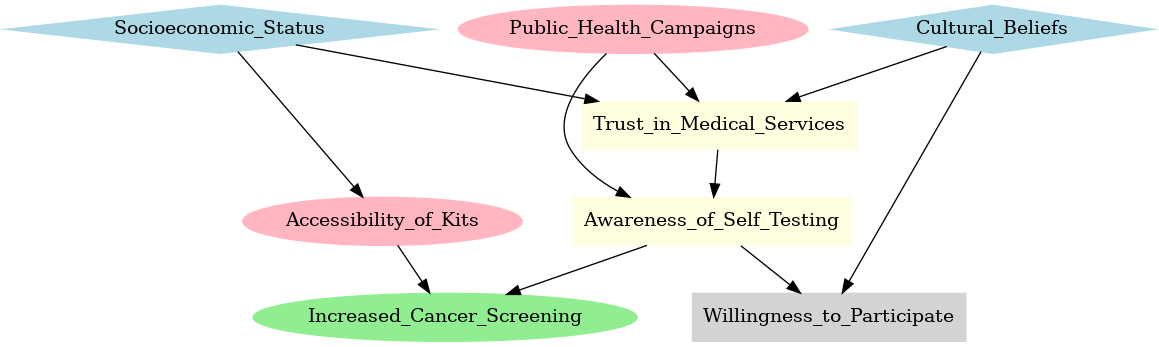

In [469]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [470]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

This article highlights an important development in public health, particularly for Māori, Pasifika, and Asian communities. By examining data from the Massey University study, which includes the number of self-testing kits distributed, the rate of return, and the positive test results, we can understand how effective these kits are in different communities. This insight could be crucial in shaping future health policies and awareness campaigns.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "affects", "

In [471]:
#################################################

structure_raw = '''
[
    {"sentence": "An intriguing aspect of this analysis is how people's willingness to participate in self-testing is influenced not just by their cultural beliefs but also by how aware they are of the self-testing process itself.", "involved": ["Willingness_to_Participate", "Cultural_Beliefs", "Awareness_of_Self_Testing"]},
    {"sentence": "The analysis suggests that the general socioeconomic status of the communities plays a pivotal role, affecting both the ease of access to self-testing kits and the level of trust in medical services and health advice.", "involved": ["Socioeconomic_Status", "Accessibility_of_Kits", "Trust_in_Medical_Services"]},
    {"sentence": "Interestingly, the trust in medical services, which itself is influenced by public health campaigns, socioeconomic status, and cultural beliefs, significantly shapes how aware individuals are about self-testing.", "involved": ["Trust_in_Medical_Services", "Public_Health_Campaigns", "Socioeconomic_Status", "Cultural_Beliefs", "Awareness_of_Self_Testing"]},
    {"sentence": "Public health campaigns are seen as a direct influencer, not only boosting awareness of self-testing but also potentially impacting trust in medical services.", "involved": ["Public_Health_Campaigns", "Awareness_of_Self_Testing", "Trust_in_Medical_Services"]},
    {"sentence": "The analysis assumes that having more widespread access to self-testing kits directly leads to an increase in cervical cancer screening rates.", "involved": ["Accessibility_of_Kits", "Increased_Cancer_Screening"]},
    {"sentence": "Furthermore, how aware individuals are about self-testing is directly linked to an increase in screening rates.", "involved": ["Awareness_of_Self_Testing", "Increased_Cancer_Screening"]},
    {"sentence": "It's assumed that cultural beliefs play a subtle yet important role, indirectly impacting the screening rates by influencing trust in medical services and willingness to participate.", "involved": ["Cultural_Beliefs", "Trust_in_Medical_Services", "Willingness_to_Participate"]}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [472]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

This article highlights an important development in public health, particularly for Māori, Pasifika, and Asian communities. By examining data from the Massey University study, which includes the number of self-testing kits distributed, the rate of return, and the positive test results, we can understand how effective these kits are in different communities. This insight could be crucial in shaping future health policies and awareness campaigns.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Public_Health_Campaigns" is "Active campaigns" (rather than "No campaigns")?
2. what is the probability that "Socioeconomic_Status" is "High socioeconomic status" (rather than "Low socioeconomic status")?
3. when "Socioeconomic_Status" is "Low socioeconomic status": what is the prob

In [473]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.6, 0.7],
  "2": [0.3, 0.4],
  "3": [0.2, 0.3],
  "4": [0.7, 0.8],
  "5": [0.5, 0.6],
  "6": [0.2, 0.3],
  "7": [0.3, 0.4],
  "8": [0.4, 0.5],
  "9": [0.5, 0.6],
  "10": [0.3, 0.4],
  "11": [0.4, 0.5],
  "12": [0.5, 0.6],
  "13": [0.6, 0.7],
  "14": [0.2, 0.3],
  "15": [0.4, 0.5],
  "16": [0.3, 0.4],
  "17": [0.6, 0.7],
  "18": [0.1, 0.2],
  "19": [0.3, 0.4],
  "20": [0.4, 0.5],
  "21": [0.6, 0.7],
  "22": [0.3, 0.4],
  "23": [0.4, 0.5],
  "24": [0.5, 0.6],
  "25": [0.7, 0.8]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [474]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions).item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

--------------------------  --------------  -----------------  ---------------------------------------------------------------------
Public_Health_Campaigns     No campaigns    Active campaigns   Implementation of public health campaigns to promote self-testing
Accessibility_of_Kits       Limited access  Widespread access  Availability and ease of access to HPV self-testing kits
Increased_Cancer_Screening  No increase     Increase           Increase in cervical cancer screening rates in the target communities
--------------------------  --------------  -----------------  ---------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Public_Health_Campaigns' means Implementation of public health campaigns to promote self-testing
'Socioeconomic_Status' means General socioeconomic status of the target communities
'Accessibility_of_Kits' means Availability and ease of access to HPV self-testing kits
'Cultural_Beliefs' means Prevailing cultural beliefs and practices regarding health and screening in the communities
'Trust_in_Medical_Services' means Degree of trust in medical services and health advice
'Awareness_of_Self_Testing' means Level of awareness about the availability and benefits of self-testing for HPV
'Increased_Cancer_Screening' means Increase in cervical cancer screening rates in the target communities
'Willingness_to_Participate' means Willingness of individuals in the communities to participate in self-testing
Treatment Value    Treatment                Outcome Value    Outcome                           ATE    Correlation
-----------------  -----------------------  ---------------  ---------------------

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                         ATE    Correlation  Outcome
----------------------------------------------  -----  -------------  ----------------------------------------------
Active campaigns Public_Health_Campaigns         0              0     High socioeconomic status Socioeconomic_Status
Active campaigns Public_Health_Campaigns         0              0     Widespread access Accessibility_of_Kits
Active campaigns Public_Health_Campaigns         0              0     Modern/Progressive beliefs Cultural_Beliefs
Active campaigns Public_Health_Campaigns         0.12           0.12  High trust Trust_in_Medical_Services
Active campaigns Public_Health_Campaigns         0.16           0.15  High awareness Awareness_of_Self_Testing
Active campaigns Public_Health_Campaigns         0.03           0.03  Increase Increased_Cancer_Screening
Active campaigns Public_Health_Campaigns         0.03           0.03  Willing Willingness_to_Participate
High socioeconomic status Socioecon

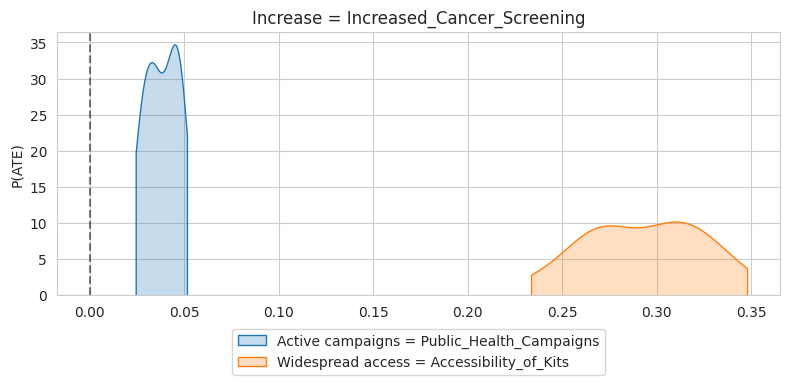

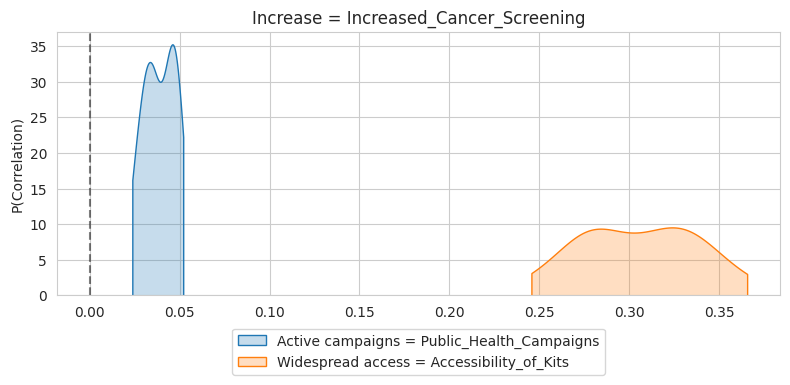

In [475]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [476]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Public_Health_Campaigns' (0='No campaigns', 1='Active campaigns') means Implementation of public health campaigns to promote self-testing
Variable 'Socioeconomic_Status' (0='Low socioeconomic status', 1='High socioeconomic status') me

In [477]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Public_Health_Campaigns": {
    "descriptor": ["public health campaign activity", "the presence of public health campaigns"],
    "subject": "the community",
    "predicate0": ["is not seeing any public health campaigns", "is devoid of public health campaigns"],
    "predicate1": ["is experiencing active public health campaigns", "is benefiting from ongoing public health campaigns"],
    "pronoun": "it",
    "nounclause0": ["there are no public health campaigns", "public health campaigns are absent"],
    "nounclause1": ["public health campaigns are in full swing", "public health campaigns are actively ongoing"],
    "preposition": ["within", "across"],
    "domain": "the community",
    "subclause0": ["public health campaigns are not being conducted", "no public health initiatives are observed"],
    "subclause1": ["public health campaigns are actively promoting self-testing", "active public health initiatives are visible"],
    "condition0": ["In areas without public health campaigns", "Where public health campaigns are absent"],
    "condition1": ["In regions with active public health campaigns", "Where public health campaigns are ongoing"],
    "action0": ["public health campaigns are halted", "public health initiatives are discontinued"],
    "action1": ["public health campaigns are launched", "public health initiatives are introduced"]
  },
  "Socioeconomic_Status": {
    "descriptor": ["the socioeconomic status", "the economic standing of the community"],
    "subject": "the community",
    "predicate0": ["faces economic hardships", "is economically disadvantaged"],
    "predicate1": ["enjoys a high socioeconomic status", "is economically prosperous"],
    "pronoun": "it",
    "nounclause0": ["the community is economically struggling", "the area has a low socioeconomic status"],
    "nounclause1": ["the community is economically well-off", "the area has a high socioeconomic status"],
    "preposition": ["among", "within"],
    "domain": "communities",
    "subclause0": ["economic struggles are evident", "there is a struggle with economic stability"],
    "subclause1": ["economic prosperity is visible", "financial stability is apparent"],
    "condition0": ["In economically struggling areas", "In communities with low economic standing"],
    "condition1": ["In economically prosperous areas", "In communities with high economic standing"],
    "action0": ["economic conditions deteriorate", "the socioeconomic status declines"],
    "action1": ["economic conditions improve", "the socioeconomic status rises"]
  },
  "Accessibility_of_Kits": {
    "descriptor": ["accessibility of self-testing kits", "availability of HPV self-testing kits"],
    "subject": "self-testing kits",
    "predicate0": ["are hard to come by", "are not readily accessible"],
    "predicate1": ["are widely accessible", "are easily available"],
    "pronoun": "they",
    "nounclause0": ["self-testing kits are scarce", "it's hard to find self-testing kits"],
    "nounclause1": ["self-testing kits are readily available", "there's easy access to self-testing kits"],
    "preposition": ["among", "in"],
    "domain": "communities",
    "subclause0": ["finding a self-testing kit is challenging", "there's a scarcity of self-testing kits"],
    "subclause1": ["self-testing kits are at hand", "access to self-testing kits is straightforward"],
    "condition0": ["Where self-testing kits are scarce", "In areas with limited access to self-testing kits"],
    "condition1": ["Where self-testing kits are abundant", "In areas with widespread access to self-testing kits"],
    "action0": ["access to self-testing kits is restricted", "self-testing kits become scarce"],
    "action1": ["access to self-testing kits is expanded", "self-testing kits become widely available"]
  },
  "Cultural_Beliefs": {
    "descriptor": ["the cultural outlook on health", "the prevailing health beliefs in the community"],
    "subject": "the community",
    "predicate0": ["holds traditional health beliefs", "adheres to conventional health practices"],
    "predicate1": ["embraces modern health beliefs", "is open to progressive health practices"],
    "pronoun": "it",
    "nounclause0": ["traditional health beliefs are dominant", "conventional health practices are followed"],
    "nounclause1": ["modern health beliefs are prevalent", "progressive health practices are adopted"],
    "preposition": ["among", "within"],
    "domain": "the community",
    "subclause0": ["traditional views on health are upheld", "there is a preference for conventional health practices"],
    "subclause1": ["a modern approach to health is seen", "progressive health beliefs are evident"],
    "condition0": ["In communities with traditional health beliefs", "Where conventional health practices are prevalent"],
    "condition1": ["In communities with modern health beliefs", "Where progressive health practices are adopted"],
    "action0": ["traditional health beliefs are reinforced", "conventional health practices are maintained"],
    "action1": ["modern health beliefs are embraced", "progressive health practices are adopted"]
  },
  "Trust_in_Medical_Services": {
    "descriptor": ["the level of trust in medical services", "the community's faith in health advice"],
    "subject": "the community",
    "predicate0": ["has little trust in medical services", "is skeptical about health advice"],
    "predicate1": ["places high trust in medical services", "values health advice greatly"],
    "pronoun": "it",
    "nounclause0": ["medical services are not highly trusted", "there's skepticism towards health advice"],
    "nounclause1": ["medical services are highly trusted", "there's a strong belief in health advice"],
    "preposition": ["among", "within"],
    "domain": "the community",
    "subclause0": ["trust in medical advice is low", "skepticism towards medical services is evident"],
    "subclause1": ["trust in medical advice is high", "confidence in medical services is apparent"],
    "condition0": ["In communities with low trust in medical services", "Where skepticism towards health advice prevails"],
    "condition1": ["In communities with high trust in medical services", "Where there is strong faith in health advice"],
    "action0": ["trust in medical services declines", "confidence in health advice wanes"],
    "action1": ["trust in medical services increases", "confidence in health advice strengthens"]
  },
  "Awareness_of_Self_Testing": {
    "descriptor": ["awareness of self-testing for HPV", "the level of knowledge about self-testing benefits"],
    "subject": "the public",
    "predicate0": ["is not well-informed about self-testing", "lacks awareness of self-testing benefits"],
    "predicate1": ["is highly aware of self-testing", "is well-informed about self-testing benefits"],
    "pronoun": "they",
    "nounclause0": ["people are unaware of self-testing benefits", "there's a lack of knowledge about self-testing"],
    "nounclause1": ["people are highly aware of self-testing benefits", "there's widespread knowledge about self-testing"],
    "preposition": ["among", "in"],
    "domain": "the population",
    "subclause0": ["knowledge about self-testing is limited", "there's little awareness of self-testing benefits"],
    "subclause1": ["knowledge about self-testing is widespread", "awareness of self-testing benefits is high"],
    "condition0": ["Where there is low awareness of self-testing", "If people are not well-informed about self-testing"],
    "condition1": ["Where there is high awareness of self-testing", "If people are well-informed about self-testing"],
    "action0": ["awareness of self-testing is reduced", "knowledge about self-testing decreases"],
    "action1": ["awareness of self-testing increases", "knowledge about self-testing expands"]
  },
  "Increased_Cancer_Screening": {
    "descriptor": ["the rate of cancer screening", "the increase in cervical cancer screening"],
    "subject": "cancer screening efforts",
    "predicate0": ["do not show an increase", "remain unchanged"],
    "predicate1": ["are on the rise", "show a significant increase"],
    "pronoun": "they",
    "nounclause0": ["there is no increase in cancer screening", "cancer screening rates remain static"],
    "nounclause1": ["there is a rise in cancer screening rates", "cancer screening efforts are increasing"],
    "preposition": ["among", "in"],
    "domain": "the community",
    "subclause0": ["no growth in cancer screening is observed", "cancer screening rates are not improving"],
    "subclause1": ["a significant increase in cancer screening is seen", "cancer screening efforts are intensifying"],
    "condition0": ["If cancer screening does not increase", "When cancer screening rates stay the same"],
    "condition1": ["If cancer screening increases", "When cancer screening rates rise"],
    "action0": ["cancer screening is not intensified", "efforts in cancer screening do not increase"],
    "action1": ["cancer screening efforts are stepped up", "the intensity of cancer screening increases"]
  },
  "Willingness_to_Participate": {
    "descriptor": ["readiness to self-test", "willingness to participate in self-testing"],
    "subject": "individuals in the community",
    "predicate0": ["are not keen on self-testing", "show reluctance towards self-testing"],
    "predicate1": ["are open to self-testing", "show eagerness to participate in self-testing"],
    "pronoun": "they",
    "nounclause0": ["people are hesitant to self-test", "there's reluctance towards self-testing"],
    "nounclause1": ["people are willing to self-test", "there's enthusiasm for self-testing"],
    "preposition": ["among", "within"],
    "domain": "the population",
    "subclause0": ["individuals show little interest in self-testing", "there's a general hesitation towards self-testing"],
    "subclause1": ["many are ready to self-test", "a general willingness for self-testing is observed"],
    "condition0": ["if people are hesitant about self-testing", "when there's little interest in self-testing"],
    "condition1": ["if people show interest in self-testing", "when the community is open to self-testing"],
    "action0": ["self-testing is not promoted", "there's a lack of encouragement for self-testing"],
    "action1": ["self-testing is actively encouraged", "efforts to promote self-testing are made"]
  }
}
'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [478]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

This article highlights an important development in public health, particularly for Māori, Pasifika, and Asian communities. By examining data from the Massey University study, which includes the number of self-testing kits distributed, the rate of return, and the positive test results, we can understand how effective these kits are in different communities. This insight could be crucial in shaping future health policies and awareness campaigns.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Public_Health_Campaigns') > 0
	2. ATE('Accessibility_of_Kits') < 0
	3. ATE('Public_Health_Campaigns') < ATE('Accessibility_of_Kits')
	4. |ATE('Public_Health_Campaigns')| > |ATE('Accessibility_of_Kits')|
	5. CATE('Public_Health_Campaigns' | 'Socioeconomic_Status'

In [479]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {
        "question": "Do public health campaigns effectively increase cervical cancer screening rates?",
        "answer": "yes",
        "claim": "Public health campaigns effectively increase cervical cancer screening rates."
    },
    "2": {
        "question": "Does having widespread access to self-testing kits decrease cancer screening rates?",
        "answer": "no",
        "claim": "Widespread access to self-testing kits does not decrease cancer screening rates."
    },
    "3": {
        "question": "Are public health campaigns more effective than widespread access to self-testing kits in increasing cancer screening rates?",
        "answer": "no",
        "claim": "Public health campaigns are not more effective than widespread access to self-testing kits in increasing cancer screening rates."
    },
    "4": {
        "question": "Is the impact of public health campaigns on cancer screening rates greater than the impact of accessibility of self-testing kits?",
        "answer": "yes",
        "claim": "The impact of public health campaigns on cancer screening rates is greater than the impact of accessibility of self-testing kits."
    },
    "5": {
        "question": "Do public health campaigns increase cancer screening rates in communities with low socioeconomic status?",
        "answer": "yes",
        "claim": "In communities with low socioeconomic status, public health campaigns increase cancer screening rates."
    },
    "6": {
        "question": "In communities with low socioeconomic status, does widespread access to self-testing kits decrease cancer screening rates?",
        "answer": "no",
        "claim": "In communities with low socioeconomic status, widespread access to self-testing kits does not decrease cancer screening rates."
    },
    "7": {
        "question": "In communities with low socioeconomic status, is the impact of widespread access to self-testing kits on cancer screening rates less than that of public health campaigns?",
        "answer": "yes",
        "claim": "In communities with low socioeconomic status, the impact of widespread access to self-testing kits on cancer screening rates is less than that of public health campaigns."
    },
    "8": {
        "question": "In communities with low socioeconomic status, is the absolute impact of public health campaigns on cancer screening rates less than that of accessibility of self-testing kits?",
        "answer": "no",
        "claim": "In communities with low socioeconomic status, the absolute impact of public health campaigns on cancer screening rates is not less than that of accessibility of self-testing kits."
    },
    "9": {
        "question": "Do public health campaigns increase cancer screening rates in communities with high socioeconomic status?",
        "answer": "yes",
        "claim": "In communities with high socioeconomic status, public health campaigns increase cancer screening rates."
    },
    "10": {
        "question": "In communities with high socioeconomic status, does widespread access to self-testing kits increase cancer screening rates?",
        "answer": "yes",
        "claim": "In communities with high socioeconomic status, widespread access to self-testing kits increases cancer screening rates."
    },
    "11": {
        "question": "In communities with high socioeconomic status, is the impact of public health campaigns on cancer screening rates greater than that of accessibility of self-testing kits?",
        "answer": "no",
        "claim": "In communities with high socioeconomic status, the impact of public health campaigns on cancer screening rates is not greater than that of accessibility of self-testing kits."
    },
    "12": {
        "question": "In communities with high socioeconomic status, is the absolute impact of public health campaigns on cancer screening rates less than that of accessibility of self-testing kits?",
        "answer": "yes",
        "claim": "In communities with high socioeconomic status, the absolute impact of public health campaigns on cancer screening rates is less than that of accessibility of self-testing kits."
    },
    "13": {
        "question": "Is the impact of public health campaigns on cancer screening rates greater in communities with high socioeconomic status than in those with low socioeconomic status?",
        "answer": "yes",
        "claim": "The impact of public health campaigns on cancer screening rates is greater in communities with high socioeconomic status than in those with low socioeconomic status."
    },
    "14": {
        "question": "Is the absolute impact of public health campaigns on cancer screening rates greater in communities with high socioeconomic status than in those with low socioeconomic status?",
        "answer": "yes",
        "claim": "The absolute impact of public health campaigns on cancer screening rates is greater in communities with high socioeconomic status than in those with low socioeconomic status."
    },
    "15": {
        "question": "Is the impact of widespread access to self-testing kits on cancer screening rates greater in communities with high socioeconomic status than in those with low socioeconomic status?",
        "answer": "yes",
        "claim": "The impact of widespread access to self-testing kits on cancer screening rates is greater in communities with high socioeconomic status than in those with low socioeconomic status."
    },
    "16": {
        "question": "Is the absolute impact of widespread access to self-testing kits on cancer screening rates less in communities with high socioeconomic status than in those with low socioeconomic status?",
        "answer": "yes",
        "claim": "The absolute impact of widespread access to self-testing kits on cancer screening rates is less in communities with high socioeconomic status than in those with low socioeconomic status."
    },
    "17": {
        "question": "In communities with traditional cultural beliefs, do public health campaigns decrease cancer screening rates?",
        "answer": "no",
        "claim": "In communities with traditional cultural beliefs, public health campaigns do not decrease cancer screening rates."
    },
    "18": {
        "question": "In communities with traditional cultural beliefs, does widespread access to self-testing kits increase cancer screening rates?",
        "answer": "yes",
        "claim": "In communities with traditional cultural beliefs, widespread access to self-testing kits increases cancer screening rates."
    },
    "19": {
        "question": "In communities with traditional cultural beliefs, is the impact of widespread access to self-testing kits on cancer screening rates greater than that of public health campaigns?",
        "answer": "yes",
        "claim": "In communities with traditional cultural beliefs, the impact of widespread access to self-testing kits on cancer screening rates is greater than that of public health campaigns."
    },
    "20": {
        "question": "In communities with traditional cultural beliefs, is the absolute impact of public health campaigns on cancer screening rates less than that of accessibility of self-testing kits?",
        "answer": "yes",
        "claim": "In communities with traditional cultural beliefs, the absolute impact of public health campaigns on cancer screening rates is less than that of accessibility of self-testing kits."
    },
    "21": {
        "question": "In communities with modern/progressive cultural beliefs, do public health campaigns increase cancer screening rates?",
        "answer": "yes",
        "claim": "In communities with modern/progressive cultural beliefs, public health campaigns increase cancer screening rates."
    },
    "22": {
        "question": "In communities with modern/progressive cultural beliefs, does widespread access to self-testing kits increase cancer screening rates?",
        "answer": "yes",
        "claim": "In communities with modern/progressive cultural beliefs, widespread access to self-testing kits increases cancer screening rates."
    },
    "23": {
        "question": "In communities with modern/progressive cultural beliefs, is the impact of widespread access to self-testing kits on cancer screening rates greater than that of public health campaigns?",
        "answer": "no",
        "claim": "In communities with modern/progressive cultural beliefs, the impact of widespread access to self-testing kits on cancer screening rates is not greater than that of public health campaigns."
    },
    "24": {
        "question": "In communities with modern/progressive cultural beliefs, is the absolute impact of public health campaigns on cancer screening rates greater than that of accessibility of self-testing kits?",
        "answer": "yes",
        "claim": "In communities with modern/progressive cultural beliefs, the absolute impact of public health campaigns on cancer screening rates is greater than that of accessibility of self-testing kits."
    },
    "25": {
        "question": "Is the impact of public health campaigns on cancer screening rates greater in communities with traditional beliefs than in those with modern/progressive beliefs?",
        "answer": "no",
        "claim": "The impact of public health campaigns on cancer screening rates is not greater in communities with traditional beliefs than in those with modern/progressive beliefs."
    },
    "26": {
        "question": "Is the absolute impact of public health campaigns on cancer screening rates greater in communities with traditional beliefs than in those with modern/progressive beliefs?",
        "answer": "no",
        "claim": "The absolute impact of public health campaigns on cancer screening rates is not greater in communities with traditional beliefs than in those with modern/progressive beliefs."
    },
    "27": {
        "question": "Is the impact of widespread access to self-testing kits on cancer screening rates greater in communities with traditional beliefs than in those with modern/progressive beliefs?",
        "answer": "no",
        "claim": "The impact of widespread access to self-testing kits on cancer screening rates is not greater in communities with traditional beliefs than in those with modern/progressive beliefs."
    },
    "28": {
        "question": "Is the absolute impact of widespread access to self-testing kits on cancer screening rates less in communities with traditional beliefs than in those with modern/progressive beliefs?",
        "answer": "yes",
        "claim": "The absolute impact of widespread access to self-testing kits on cancer screening rates is less in communities with traditional beliefs than in those with modern/progressive beliefs."
    }
}

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [480]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Effectiveness_of_HPV_Self-Testing_in_Māori_Pasifika_Asian_Communities.json'